# Experiments 2–4: DeBERTa-v3-base + Extra Features

We continue from Experiment 1 (raw DeBERTa fine-tuning) by augmenting the classifier head with hand-crafted linguistic features derived from the EDA:

2. **POS + NER features** (35 dim) – proportion of each Universal POS tag (16) and NER entity type (18) per document, plus entity density (1).
3. **Fightin' Words z-score features** (6 dim) – aggregated log-odds z-scores (Monroe et al., 2008) capturing per-document lexical class association.
4. **All features combined** (41 dim) – POS/NER + z-score features together.

The hyperparameter search **restricts** the most impactful parameters from Experiment 1 (learning rate, warmup fraction) to a narrow productive range, while **expanding** the search for head architecture parameters (hidden dim, dropout, pooling, head LR multiplier) that may behave differently with extra features concatenated to the pooled embedding.

In [ ]:
import os
import random
import logging
import gc
import re
from enum import Enum
from itertools import combinations, chain
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
import spacy
import optuna
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate
)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Import utils
from utils.data import load_data, clean_text
from utils.split import split_train_val
from utils.feature import extract_pos_ner_features, extract_pos_features, extract_ner_features, FeatureType
from utils.optim import get_cosine_schedule_with_warmup, compute_pos_weight 
from utils.fightin_words import compute_fightin_words_zscores, extract_zscore_features
from utils.dataloaders import make_dataloaders
from utils.pcl_deberta import PCLDeBERTa, PoolingStrategy
from utils.training_loop import train_model
from utils.eval import evaluate
from utils.feature_comb import FeatureComb

SEED = 42
DATA_DIR = "data"
OUT_DIR = "out"
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LENGTH = 256
VAL_FRACTION = 0.15
N_TRIALS = 20
NUM_EPOCHS = 20
PATIENCE = 6
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fixed ordered lists for consistent feature dimensions
POS_TAGS = ["NOUN", "VERB", "ADP", "ADJ", "DET", "AUX", "PROPN", "PRON", "CCONJ", "ADV"]
NER_TYPES = ["ORG", "GPE", "PERSON", "DATE", "CARDINAL", "NORP", "LOC", "ORDINAL", "MONEY"]
ZSCORE_FEAT_NAMES = ["mean_z", "max_z", "min_z", "std_z", "frac_pos_z", "frac_neg_z"]
ZSCORE_THRESHOLD = 1.96  # significance level for frac_pos/frac_neg

N_POS_FEATURES = len(POS_TAGS) + 1                         # 16
N_NER_FEATURES = len(NER_TYPES) + 1                     # 18 types + entity_density = 19
N_POS_NER_FEATURES = N_POS_FEATURES + N_NER_FEATURES    # 35
N_ZSCORE_FEATURES = len(ZSCORE_FEAT_NAMES)              # 6
N_ALL_FEATURES = N_POS_NER_FEATURES + N_ZSCORE_FEATURES # 41
EXTRA_FEAT_DICT = {
    FeatureType.POS: N_POS_FEATURES,
    FeatureType.NER: N_NER_FEATURES,
    FeatureType.ZSCORE: N_ZSCORE_FEATURES,
}

BATCH_SIZE = 48
VAL_FRACTION = 0.25
N_EVAL_STEPS = 35
POOLING = PoolingStrategy.CLS_MEAN

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s:\t%(message)s")
LOG = logging.getLogger(__name__)
LOG.info(f"Device: {DEVICE}")
LOG.info(f"Feature dims — POS: {N_POS_FEATURES}, NER: {N_NER_FEATURES}, "
         f"POS+NER: {N_POS_NER_FEATURES}, Z-score: {N_ZSCORE_FEATURES}, All: {N_ALL_FEATURES}")

2026-02-23 21:39:48,342 INFO:	Device: cuda
2026-02-23 21:39:48,344 INFO:	Feature dims — POS: 11, NER: 10, POS+NER: 21, Z-score: 6, All: 27


## 1. Data Loading and Preprocessing
Identical to Experiment 1: load PCL dataset, join with official SemEval train/dev splits, binarise labels, and clean HTML artifacts.

In [2]:
train_df, dev_df = load_data(DATA_DIR)
matches = 0
for df in [train_df, dev_df]:
    for row in df.itertuples():
        para = str(row.text)
        for match in re.finditer(r"<[^>]+>|<\/[^>]+>|&\w+;|\n|\\n|\s{2,}|\r|\\r|@@\d+|[^\x00-\x7F]+|https?://\S+", para):
            LOG.warning(f"Found noise in par_id {row.Index}: '{match.group(0)}'")
            matches += 1
LOG.info(f"Total noise matches found: {matches}")

# Stratified split using utils
train_sub_df, val_sub_df = split_train_val(train_df, val_frac=VAL_FRACTION, seed=SEED)

# Get dataloaders for training and validation
tokeniser = AutoTokenizer.from_pretrained(MODEL_NAME)

2026-02-23 21:39:49,228 INFO:	Total noise matches found: 0
2026-02-23 21:39:49,271 INFO:	Train/val split: 6281 train, 2094 val (val_frac=0.25)
2026-02-23 21:39:49,272 INFO:	Train, val positive count: 595, 199
2026-02-23 21:39:49,448 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 21:39:49,459 INFO:	HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/microsoft/deberta-v3-base/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/config.json "HTTP/1.1 200 OK"
2026-02-23 21:39:49,850 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/tokenizer_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 21:39:49,851 WARNING:	Warning: You are sending unauthenticated requests to the HF Hub. Please set a HF_TOKEN to enable higher rate limits and faster downloads.
2026-02-23 21:39:49,859 INFO:	HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/micro

## 2. Feature Extraction

We extract three categories of features to concatenate with the DeBERTa pooled embedding:

1. **POS proportions** (16 dim): Fraction of non-punctuation tokens with each Universal POS tag. The EDA showed subtle but consistent differences (e.g., more ADJ/ADV in PCL text, fewer NOUN).
2. **NER proportions + density** (19 dim): Fraction of named entities of each type (18 types) plus overall entity density (entities per token). PCL text tends to reference people and groups differently.
3. **Fightin' Words z-scores** (6 dim): Aggregated log-odds z-scores (Monroe et al., 2008) capturing lexical class association. For each document we compute mean, max, min, std of matched n-gram z-scores, plus fraction of n-grams above/below significance threshold (|z| > 1.96).

The z-score dictionary is computed from `train_df` only (not dev) to avoid data leakage. Feature normalisation (`StandardScaler`) is fit on `train_sub_df`.

In [3]:
# Process all texts with spaCy (done once, shared across experiments)
gpu = spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
LOG.info(f"spaCy using {'GPU' if gpu else 'CPU'}.")
# We only use train_df for feature extraction since we do not want data leakage.
train_docs = {}
for parid, doc in zip(
    train_sub_df.index.tolist(),
    nlp.pipe(train_sub_df["text"].tolist(), batch_size=256)
):
    train_docs[parid] = doc
LOG.info(f"spaCy processing complete: {len(train_docs)} documents")

2026-02-23 21:39:53,675 INFO:	spaCy using GPU.
2026-02-23 21:40:32,695 INFO:	spaCy processing complete: 6281 documents


In [4]:
# POS/NER feature extraction using utils
epid = 7
pos_features = {}
ner_features = {}
for pid, doc in train_docs.items():
    pos_features[pid], ner_features[pid] = extract_pos_ner_features(doc, POS_TAGS, NER_TYPES)

assert len(pos_features[epid]) + len(ner_features[epid]) == N_POS_NER_FEATURES, f"Expected {N_POS_NER_FEATURES} features, got {len(pos_features) + len(ner_features)}"
LOG.info(f"POS+NER features extracted: {N_POS_NER_FEATURES} dims per document")

2026-02-23 21:40:33,026 INFO:	POS+NER features extracted: 21 dims per document


In [5]:
# Fightin' Words z-score computation using utils
Z_SCORES, log_odds, pos_counts, neg_counts = compute_fightin_words_zscores(train_docs.values(), train_sub_df["binary_label"].tolist())
LOG.info(f"Extracted z_scores from train subset")

2026-02-23 21:40:33,391 INFO:	Detected binary label.
2026-02-23 21:40:34,123 INFO:	Extracted z_scores from train subset


In [6]:
# Build z-score feature dict for all documents
zscore_features = {}
for pid, doc in train_docs.items():
    zscore_features[pid] = extract_zscore_features(doc, Z_SCORES)

assert zscore_features[epid].shape == (N_ZSCORE_FEATURES,), \
    f"Expected {N_ZSCORE_FEATURES} features, got {zscore_features[epid].shape}"
LOG.info(f"Z-score features extracted: {N_ZSCORE_FEATURES} dims per document")
LOG.info(f"Example z-score features for paragraph ID {epid}:\n{zscore_features[epid]}")

2026-02-23 21:40:35,053 INFO:	Z-score features extracted: 6 dims per document
2026-02-23 21:40:35,055 INFO:	Example z-score features for paragraph ID 7:
[-0.13518582  1.1641461  -1.218259    0.5135633   0.          0.        ]


In [7]:
def get_features_nolabel_dict(para_dict: dict[int, dict[str, float]]) -> np.ndarray:
    return get_features_nolabel(list(para_dict.values()))

def get_features_nolabel(paras: list[dict[str, float]]) -> np.ndarray:
    return np.stack([list(para.values()) for para in paras])

# Combined feature dict for Experiment 4 (POS+NER + z-scores)
pos_features_np = get_features_nolabel_dict(pos_features)
ner_features_np = get_features_nolabel_dict(ner_features)
zscore_features_np = np.stack(list(zscore_features.values()))
pos_ner_features_np = np.concatenate([pos_features_np, ner_features_np], axis=1)
all_features = np.concatenate([pos_ner_features_np, zscore_features_np], axis=1)
LOG.info(f"POS features shape:\t{pos_features_np.shape}\n"
         f"NER features shape:\t{ner_features_np.shape}\n"
         f"Z-score features shape:\t{zscore_features_np.shape}\n"
         f"POS+NER features shape:\t{pos_ner_features_np.shape}\n"
         f"All features shape:\t{all_features.shape}")
assert all_features[epid].shape == (N_ALL_FEATURES,), \
    f"Expected {N_ALL_FEATURES}, got {all_features[epid].shape}"

# Fit StandardScalers on train_sub features (avoid val/dev leakage)
pos_scaler = StandardScaler()
pos_scaler.fit(pos_features_np)

ner_scaler = StandardScaler()
ner_scaler.fit(ner_features_np)

zscore_scaler = StandardScaler()
zscore_scaler.fit(zscore_features_np)

def get_scaled_features(
    pos_features: list[dict[str, float]] | None = None,
    ner_features: list[dict[str, float]] | None = None,
    zscore_features: list[np.ndarray] | None = None,
) -> np.ndarray:
    """Assemble and scale features for given par_ids."""
    pos_scaled, ner_scaled, zscore_scaled = None, None, None
    if pos_features is not None:
        pos_features_np = get_features_nolabel(pos_features)
        pos_scaled = pos_scaler.transform(pos_features_np)
    if ner_features is not None:
        ner_features_np = get_features_nolabel(ner_features)
        ner_scaled = ner_scaler.transform(ner_features_np)
    if zscore_features is not None:
        zscore_features_np = np.stack(list(zscore_features))
        zscore_scaled = zscore_scaler.transform(zscore_features_np)
    
    feats = [feat for feat in [pos_scaled, ner_scaled, zscore_scaled] if feat is not None]
    all_scaled = np.concatenate(feats, axis=1, dtype=np.float32)
    
    return all_scaled

LOG.info("Feature scalers fitted on train_sub")

# Free spaCy docs to reclaim memory (features are already extracted)
del train_docs
gc.collect()

2026-02-23 21:40:35,116 INFO:	POS features shape:	(6281, 11)
NER features shape:	(6281, 10)
Z-score features shape:	(6281, 6)
POS+NER features shape:	(6281, 21)
All features shape:	(6281, 27)
2026-02-23 21:40:35,121 INFO:	Feature scalers fitted on train_sub


0

## 3. Dataset, DataLoader, and Model Architecture
All the same as before!

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
LOG.info(f"Tokenizer loaded: {tokenizer.__class__.__name__}")


2026-02-23 21:40:35,501 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 21:40:35,511 INFO:	HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/microsoft/deberta-v3-base/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/config.json "HTTP/1.1 200 OK"
2026-02-23 21:40:35,616 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/tokenizer_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 21:40:35,626 INFO:	HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/microsoft/deberta-v3-base/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/tokenizer_config.json "HTTP/1.1 200 OK"
2026-02-23 21:40:35,730 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 404 Not Found"
2026-02-23 21:40:35,836 INFO:	HTTP Request: GET https://huggingface.co/api/model

## 4. Training Infrastructure
Weighted BCE loss for class imbalance, cosine annealing with warmup, early stopping, and evaluation utilities — all modified to pass extra features through the pipeline.

In [9]:
def extra_feature_factory(paras: list[str], extra_features: list[FeatureType], log=True) -> torch.Tensor:
    pos_features, ner_features, z_scores = None, None, None
    LOG.info(f"Generating extra features...")
    for doc in nlp.pipe(paras):
        if FeatureType.POS in extra_features:
            pos_features = pos_features or [] 
            pos_features.append(extract_pos_features(doc, POS_TAGS))
        if FeatureType.NER in extra_features:
            ner_features = ner_features or []
            ner_features.append(extract_ner_features(doc, NER_TYPES))
        if FeatureType.ZSCORE in extra_features:
            z_scores = z_scores or []
            z_scores.append(extract_zscore_features(doc, Z_SCORES))
    scaled_feats = get_scaled_features(pos_features, ner_features, z_scores)
    LOG.info(f"Finished generating extra features...")
    return torch.Tensor(scaled_feats).to(DEVICE)

## 5. Hyperparameter Search

We use a shared objective factory for all three experiments. The search space reflects Experiment 1 findings:
- **Restricted** (most impactful from Exp 1 importance plot): `lr` ∈ [8e-6, 4e-5], `warmup_fraction` ∈ {0.06, 0.08, 0.10, 0.12}
- **Expanded** (may change with extra features in the head): `hidden_dim` ∈ {0, 64, 128, 256, 384, 512, 768}, `dropout` ∈ [0, 0.5], `pooling` ∈ {cls, mean, max, cls_mean}, `head_lr_multiplier` ∈ {1, 3, 5, 10, 15}, `label_smoothing` ∈ [0, 0.2]

In [ ]:
def make_objective(
    exp_name: str,
    extra_features: list[FeatureType],
    feature_comb_method: bool = FeatureComb.CONCAT,
):
    """
    Factory returning an Optuna objective function for the given experiment.
    Closes over the feature data and experiment configuration.
    """

    def objective(trial: optuna.trial.Trial) -> float:
        # --- Restricted hyperparameters (most impactful from Exp 1) ---
        lr = trial.suggest_float("lr", 4e-6, 5e-5, log=True)
        warmup_fraction = trial.suggest_float("warmup_fraction", 0.03, 0.09, step=0.01)

        # --- Expanded hyperparameters (head may differ with extra features) ---
        hidden_dim = trial.suggest_categorical("hidden_dim", [0, 128, 256, 512])
        dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.10) if hidden_dim > 0 else 0.0
        weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
        head_lr_multiplier = trial.suggest_categorical("head_lr_multiplier", [1, 5, 7, 15])
        label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.2, step=0.1)
        # Fixed
        pooling = POOLING

        LOG.info(f"[Experiment {exp_name}] | Trial {trial.number}\n"
                 f"Extra Features=\t{extra_features}\n"
                 f"lr=\t{lr:.2e}\nwarmup=\t{warmup_fraction:.2f}\nhidden=\t{hidden_dim}\n"
                 f"drop=\t{dropout_rate:.2f}\nwd=\t{weight_decay:.2e}\npool=\t{pooling.value}\n"
                 f"head_mult=\t{head_lr_multiplier}\nls=\t{label_smoothing:.3f}")
    
        n_extra_features = sum(EXTRA_FEAT_DICT[feat] for feat in extra_features)

        extra_feature_lambda = lambda paras: extra_feature_factory(paras, extra_features)
        train_loader, val_loader, dev_loader = make_dataloaders(
            train_sub_df, val_sub_df, dev_df, BATCH_SIZE, MAX_LENGTH, tokeniser, extra_feature_lambda
        )

        model = PCLDeBERTa(
            hidden_dim=hidden_dim, dropout_rate=dropout_rate,
            n_extra_features=n_extra_features, pooling=pooling
        ).to(DEVICE)

        pos_weight = compute_pos_weight(train_sub_df, DEVICE)

        results = train_model(
            model=model, train_loader=train_loader,
            val_loader=val_loader, dev_loader=dev_loader,
            pos_weight=pos_weight, lr=lr, weight_decay=weight_decay,
            num_epochs=NUM_EPOCHS, warmup_fraction=warmup_fraction,
            patience=PATIENCE, head_lr_multiplier=head_lr_multiplier,
            label_smoothing=label_smoothing, eval_every_n_steps=N_EVAL_STEPS, trial=trial,
            device=DEVICE,
        )

        # Store metrics on the trial for later inspection
        trial.set_user_attr("best_val_f1", results["best_val_f1"])
        trial.set_user_attr("best_threshold", results["best_threshold"])
        trial.set_user_attr("dev_f1", results["dev_metrics"]["f1"])
        trial.set_user_attr("dev_precision", results["dev_metrics"]["precision"])
        trial.set_user_attr("dev_recall", results["dev_metrics"]["recall"])

        # Save model weights if this is the best trial so far
        try:
            prev_best = trial.study.best_value
        except ValueError:
            prev_best = -float("inf")
        if results["best_val_f1"] > prev_best:
            LOG.info("New best val f1, saving model and params.")
            os.makedirs(OUT_DIR, exist_ok=True)
            torch.save({k: v.cpu() for k, v in model.state_dict().items()},
                       os.path.join(OUT_DIR, f"exp_{exp_name}_best_model.pt"))
            config = {**trial.params, "batch_size": BATCH_SIZE, "num_epochs": NUM_EPOCHS,
                        "patience": PATIENCE, "best_threshold": results["best_threshold"]}
            with open(os.path.join(OUT_DIR, f"exp_{exp_name}_best_params.json"), "w") as f:
                json.dump(config, f, indent=2)
            LOG.info(f"Experiment [{exp_name}] new best model and params saved (val F1={results['best_val_f1']:.4f})")


        # Aggressively free GPU memory between trials
        del model, train_loader, val_loader, dev_loader
        gc.collect()
        torch.cuda.empty_cache()

        # Optimise on threshold-tuned val F1 (not dev F1) to avoid data leakage
        return results["best_val_f1"]

    return objective

In [ ]:
def run_experiment(exp_name: str, extra_features: list[FeatureType], feature_comb_method: FeatureComb = FeatureComb.CONCAT) -> optuna.Study:
    gc.collect()
    torch.cuda.empty_cache()
    LOG.info(f"Running experiment: {exp_name}")

    study = optuna.create_study(
        direction="maximize",
        study_name=f"pcl_deberta_exp_{exp_name}",
        sampler=optuna.samplers.TPESampler(seed=SEED),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=8, n_warmup_steps=500)
    )
    study.optimize(make_objective(exp_name, extra_features, feature_comb_method), n_trials=N_TRIALS)

    best = study.best_trial
    LOG.info(f"Best trial: {best.number}")
    LOG.info(f"Val F1: {best.user_attrs['best_val_f1']:.4f} | "
                f"Dev F1: {best.user_attrs['dev_f1']:.4f} | "
                f"Dev P: {best.user_attrs['dev_precision']:.4f} | "
                f"Dev R: {best.user_attrs['dev_recall']:.4f}")
    LOG.info(f"Best params: {best.params}")
    return study

In [12]:

def show_results(study: optuna.study.Study, exp_name: str,
                 extra_features: list[FeatureType]) -> dict:
    """Visualise Optuna results and evaluate best model on dev set."""
    # Optuna plots
    for plot_fn, suffix in [(plot_optimization_history, "history"),
                            (plot_param_importances, "importances"),
                            (plot_parallel_coordinate, "parallel")]:
        plot_fn(study)
        plt.tight_layout()
        plt.savefig(f"{OUT_DIR}/{exp_name}_optuna_{suffix}.png", dpi=300)
        plt.savefig(f"{OUT_DIR}/{exp_name}_optuna_{suffix}.svg", format="svg")
        plt.show()

    # Load and evaluate best model
    best = study.best_trial
    best_params = best.params

    n_extra_features = sum(EXTRA_FEAT_DICT[feat] for feat in extra_features)
    model = PCLDeBERTa(
        hidden_dim=best_params["hidden_dim"],
        dropout_rate=best_params.get("dropout_rate", 0.0),
        n_extra_features=n_extra_features,
        pooling=POOLING
    ).to(DEVICE)

    state_dict = torch.load(
        os.path.join(OUT_DIR, f"exp_{exp_name}_best_model.pt"), map_location=DEVICE)
    model.load_state_dict(state_dict)
    LOG.info(f"[{exp_name}] Loaded best model weights")

    best_threshold = best.user_attrs["best_threshold"]

    extra_feature_lambda = lambda paras: extra_feature_factory(paras, extra_features)
    _, _, dev_loader = make_dataloaders(
        train_sub_df, val_sub_df, dev_df, BATCH_SIZE, MAX_LENGTH, tokeniser, extra_feature_lambda
    )
    dev_metrics = evaluate(
        model,
        DEVICE,
        dev_loader,
        threshold=best_threshold,
    )

    print(f"\n{'='*60}")
    print(f"{exp_name.upper()} — Dev Set Results (threshold={best_threshold:.3f})")
    print(f"{'='*60}")
    print(classification_report(
        dev_metrics["labels"], dev_metrics["preds"],
        target_names=["Non-PCL", "PCL"]
    ))

    # Save config
    config = {**best_params, "batch_size": BATCH_SIZE, "num_epochs": NUM_EPOCHS,
              "patience": PATIENCE, "best_threshold": best_threshold,
              "n_extra_features": n_extra_features}
    with open(os.path.join(OUT_DIR, f"exp_{exp_name}_best_params.json"), "w") as f:
        json.dump(config, f, indent=2)
    LOG.info(f"[{exp_name}] Saved model and params to {OUT_DIR}/")

    for k, v in best_params.items():
        print(f"  {k}: {v}")

    del model
    gc.collect()
    torch.cuda.empty_cache()
    return dev_metrics

## 6. Experiment 2: POS + NER Features (35 dim)
Fine-tune DeBERTa-v3-base with 35 additional features concatenated to the pooled embedding:
- 16 POS tag proportions (fraction of non-punct tokens per Universal POS tag)
- 18 NER entity type proportions (fraction of entities of each type)
- 1 entity density (total entities ÷ total tokens)

In [ ]:
exp2_name = "POS_NER"
exp2_extra_features = [FeatureType.POS, FeatureType.NER] 
exp3_name = "ZSCORE"
exp3_extra_features = [FeatureType.ZSCORE] 
exp4_name = "POS_NER_ZSCORE"
exp4_extra_features = [FeatureType.POS, FeatureType.NER, FeatureType.ZSCORE]
exp5_name = "POS_NER_GMF"
exp5_extra_features = [FeatureType.POS, FeatureType.NER]
exp6_name = "ZSCORE_GMF"
exp6_extra_features = [FeatureType.ZSCORE]
exp7_name = "POS_NER_ZSCORE_GMF"
exp7_extra_features = [FeatureType.POS, FeatureType.NER, FeatureType.ZSCORE]

In [ ]:
study_exp2 = run_experiment(exp2_name, exp2_extra_features)

2026-02-21 23:31:29,974 INFO:	Running experiment: POS_NER
[I 2026-02-21 23:31:29,976] A new study created in memory with name: pcl_deberta_exp_POS_NER
2026-02-21 23:31:29,979 INFO:	[Experiment POS_NER] | Trial 0
Extra Features=	[<FeatureType.POS: 'pos'>, <FeatureType.NER: 'ner'>]
lr=	1.59e-05
warmup=	0.09
hidden=	0
drop=	0.00
wd=	1.31e-04
pool=	cls_mean
head_mult=	5
ls=	0.000
2026-02-21 23:31:29,980 INFO:	Generating extra features...
2026-02-21 23:32:01,461 INFO:	Finished generating extra features...
2026-02-21 23:32:04,963 INFO:	Generating extra features...
2026-02-21 23:32:15,765 INFO:	Finished generating extra features...
2026-02-21 23:32:16,844 INFO:	Generating extra features...
2026-02-21 23:32:27,714 INFO:	Finished generating extra features...
2026-02-21 23:32:28,951 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-21 23:32:28,961 INFO:	HTTP Request: HEAD https://huggingface.co/api/resolve

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-21 23:32:31,078 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 00:16:38,316 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 00:51:42,504 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 01:33:11,265 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 02:30:14,141 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 03:50:39,128 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 04:52:59,836 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 05:41:04,375 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 06:21:24,122 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
2026-02-22 06:21:24,256 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/refs%2Fpr%2F14 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
m

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 07:05:36,877 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 07:48:32,455 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 08:37:50,335 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 09:26:02,306 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
2026-02-22 09:26:02,504 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/refs%2Fpr%2F14 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
m

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 10:10:35,629 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 10:30:59,330 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 11:29:39,680 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 11:49:50,628 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 12:38:22,375 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 13:03:02,977 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
2026-02-22 13:03:03,141 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/refs%2Fpr%2F14 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
m

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 13:48:57,297 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 14:33:38,608 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 14:54:36,905 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-22 15:36:18,262 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/refs%2Fpr%2F14/model.safetensors.index.json "HTTP/1.1 404 Not Found"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-22 16:21:11,162 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-22 17:22:55,921 INFO:	Backbone model loaded: 

In [22]:
dev_metrics_exp2 = show_results(study_exp2, exp2_name, exp2_extra_features)

NameError: name 'study_exp2' is not defined

## 7. Experiment 3: Fightin' Words z-score Features (6 dim)
Fine-tune DeBERTa-v3-base with 6 z-score features capturing lexical class association:
- mean, max, min, std of matched n-gram z-scores
- fraction of n-grams with z > 1.96 (PCL-leaning)
- fraction with z < -1.96 (non-PCL-leaning)

In [ ]:
study_exp3 = run_experiment(exp3_name, exp3_extra_features)

2026-02-23 21:40:37,196 INFO:	Running experiment: ZSCORE
[I 2026-02-23 21:40:37,199] A new study created in memory with name: pcl_deberta_exp_ZSCORE
2026-02-23 21:40:37,201 INFO:	[Experiment ZSCORE] | Trial 0
Extra Features=	[<FeatureType.ZSCORE: 'zscore'>]
lr=	1.03e-05
warmup=	0.09
hidden=	0
drop=	0.00
wd=	1.49e-05
pool=	cls_mean
head_mult=	1
ls=	0.200
2026-02-23 21:40:37,204 INFO:	Generating extra features...
2026-02-23 21:41:09,621 INFO:	Finished generating extra features...
2026-02-23 21:41:10,293 INFO:	Generating extra features...
2026-02-23 21:41:21,940 INFO:	Finished generating extra features...
2026-02-23 21:41:22,671 INFO:	Generating extra features...
2026-02-23 21:41:34,254 INFO:	Finished generating extra features...
2026-02-23 21:41:35,130 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-23 21:41:35,138 INFO:	HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/microsoft

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-23 21:41:40,801 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-23 22:44:18,434 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-23 23:53:33,310 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-24 01:01:28,456 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 01:56:06,345 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 03:07:56,188 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 04:17:10,589 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 05:17:05,824 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 06:15:40,816 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 07:16:51,839 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 07:37:41,401 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 07:58:29,922 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 08:58:24,320 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 09:47:21,038 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 10:29:26,043 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/refs%2Fpr%2F14 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 11:23:47,929 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
2026-02-24 11:23:48,078 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/refs%2Fpr%2F14 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
l

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 12:10:27,129 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 13:06:07,051 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 13:55:22,261 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 14:51:09,577 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 15:23:06,538 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
2026-02-24 15:23:06,677 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predicti

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 15:43:22,321 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 16:40:21,503 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 17:28:20,305 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 17:48:37,096 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

/tmp/ipykernel_1962/4140426235.py:8: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_fn(study)


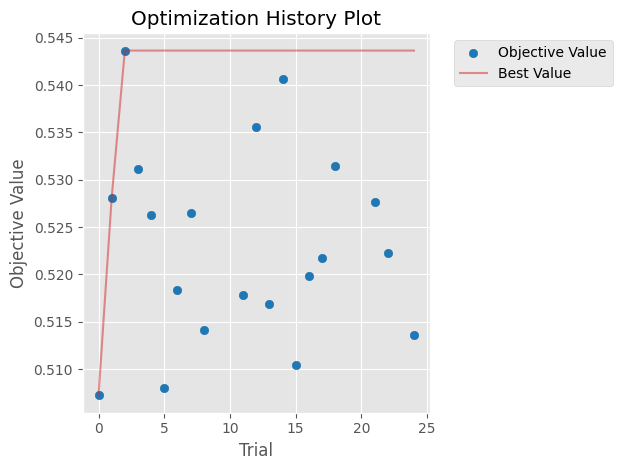

/tmp/ipykernel_1962/4140426235.py:8: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_fn(study)


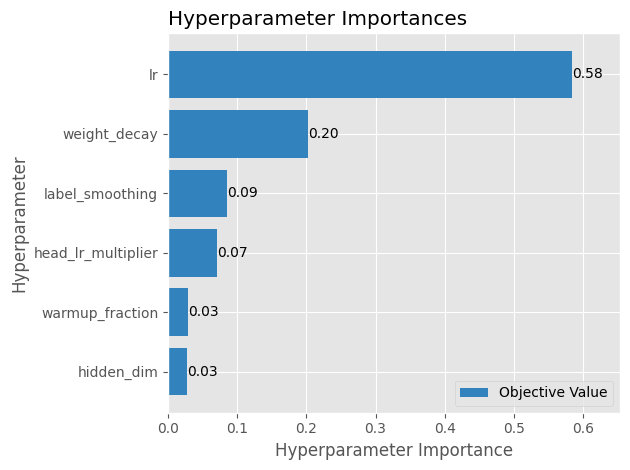

/tmp/ipykernel_1962/4140426235.py:8: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_fn(study)


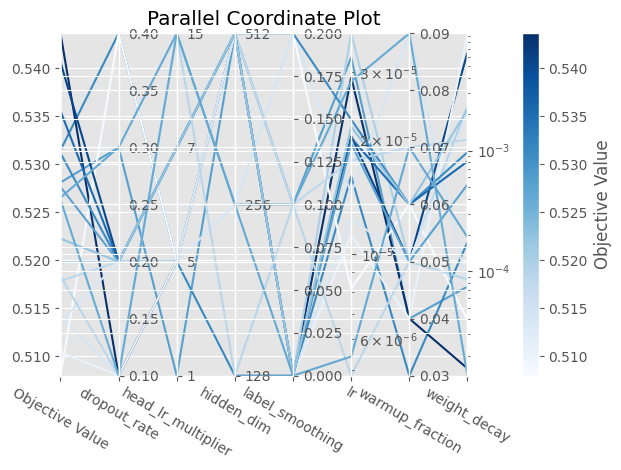

2026-02-25 20:09:59,640 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-25 20:09:59,650 INFO:	HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/microsoft/deberta-v3-base/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/config.json "HTTP/1.1 200 OK"
2026-02-25 20:09:59,747 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/model.safetensors "HTTP/1.1 404 Not Found"
2026-02-25 20:09:59,846 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base "HTTP/1.1 200 OK"
2026-02-25 20:09:59,960 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
2026-02-25 20:10:00,080 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-25 20:10:00,200 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/refs%2Fpr%2F14 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can


ZSCORE — Dev Set Results (threshold=0.675)
              precision    recall  f1-score   support

     Non-PCL       0.96      0.91      0.94      1894
         PCL       0.43      0.62      0.51       199

    accuracy                           0.89      2093
   macro avg       0.69      0.77      0.72      2093
weighted avg       0.91      0.89      0.89      2093

  lr: 2.9062124930075867e-05
  warmup_fraction: 0.04
  hidden_dim: 512
  dropout_rate: 0.1
  weight_decay: 1.5673095467235405e-05
  head_lr_multiplier: 5
  label_smoothing: 0.0


In [19]:
dev_metrics_exp3 = show_results(study_exp3, exp3_name, exp3_extra_features)

## 8. Experiment 4: POS + NER + z-score Features (41 dim)
Fine-tune DeBERTa-v3-base with all 41 features concatenated to the pooled embedding.

In [ ]:
study_exp4 = run_experiment(exp4_name, exp4_extra_features)

2026-02-24 20:10:38,001 INFO:	Running experiment: POS_NER_ZSCORE
[I 2026-02-24 20:10:38,012] A new study created in memory with name: pcl_deberta_exp_POS_NER_ZSCORE
2026-02-24 20:10:38,022 INFO:	[Experiment POS_NER_ZSCORE] | Trial 0
Extra Features=	[<FeatureType.POS: 'pos'>, <FeatureType.NER: 'ner'>, <FeatureType.ZSCORE: 'zscore'>]
lr=	1.03e-05
warmup=	0.09
hidden=	0
drop=	0.00
wd=	1.49e-05
pool=	cls_mean
head_mult=	1
ls=	0.200
2026-02-24 20:10:38,049 INFO:	Generating extra features...
2026-02-24 20:11:13,781 INFO:	Finished generating extra features...
2026-02-24 20:11:15,831 INFO:	Generating extra features...
2026-02-24 20:11:27,643 INFO:	Finished generating extra features...
2026-02-24 20:11:28,599 INFO:	Generating extra features...
2026-02-24 20:11:39,914 INFO:	Finished generating extra features...
2026-02-24 20:11:40,643 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-24 20:11:40,653 INFO:	

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-24 20:11:45,893 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-24 21:16:42,538 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-24 22:12:58,883 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-24 23:00:41,134 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/refs%2Fpr%2F14 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-24 23:55:05,497 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-25 00:43:32,707 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-25 01:43:57,214 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-25 02:48:40,965 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/refs%2Fpr%2F14 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-25 03:54:36,264 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-25 05:00:38,228 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-25 05:43:22,314 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-25 06:38:08,362 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-25 07:34:20,197 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-25 08:19:56,427 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-25 09:08:30,391 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-25 10:03:31,899 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-25 10:40:00,946 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-25 11:27:43,244 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-25 11:48:51,458 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-25 13:38:23,700 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-25 14:43:30,704 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-25 15:31:18,761 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-25 16:22:55,579 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-25 17:07:58,507 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-25 18:26:45,664 INFO:	Backbone model loaded: 

/tmp/ipykernel_1962/4140426235.py:8: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_fn(study)


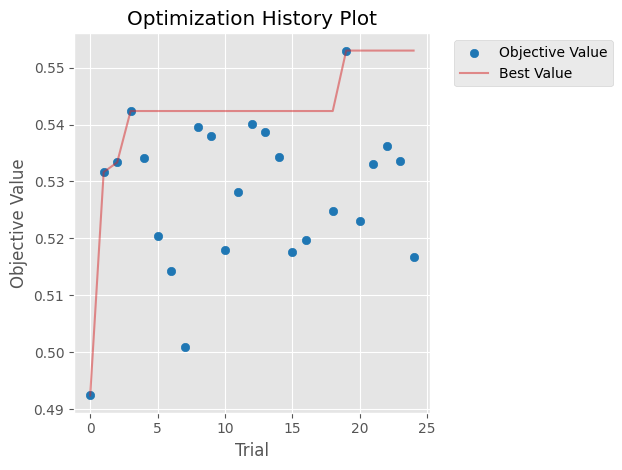

/tmp/ipykernel_1962/4140426235.py:8: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_fn(study)


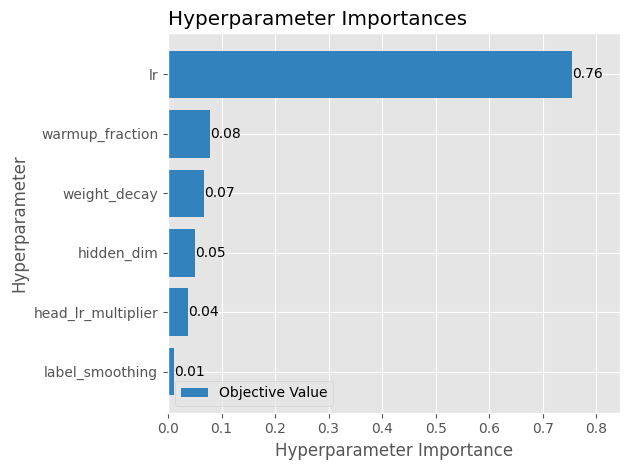

/tmp/ipykernel_1962/4140426235.py:8: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_fn(study)


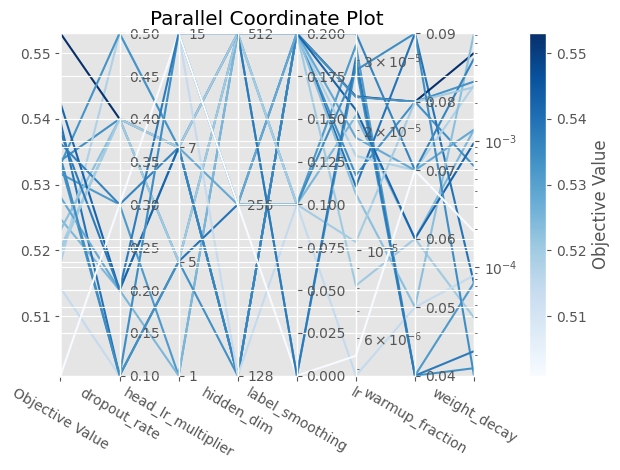

2026-02-25 20:07:14,238 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-25 20:07:14,247 INFO:	HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/microsoft/deberta-v3-base/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/config.json "HTTP/1.1 200 OK"
2026-02-25 20:07:14,376 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/model.safetensors "HTTP/1.1 404 Not Found"
2026-02-25 20:07:14,477 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base "HTTP/1.1 200 OK"
2026-02-25 20:07:14,592 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
2026-02-25 20:07:14,707 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
2026-02-25 20:07:14,816 INFO:	HTTP Request: GET https://huggingface.co/api/models/micros

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-25 20:07:20,721 INFO:	Backbone model loaded: 


POS_NER_ZSCORE — Dev Set Results (threshold=0.300)
              precision    recall  f1-score   support

     Non-PCL       0.95      0.93      0.94      1894
         PCL       0.44      0.52      0.48       199

    accuracy                           0.89      2093
   macro avg       0.69      0.73      0.71      2093
weighted avg       0.90      0.89      0.89      2093

  lr: 2.4352078417720258e-05
  warmup_fraction: 0.08
  hidden_dim: 128
  dropout_rate: 0.4
  weight_decay: 0.005019315676644375
  head_lr_multiplier: 7
  label_smoothing: 0.2


In [16]:
dev_metrics_exp4 = show_results(study_exp4, exp4_name, exp4_extra_features)

## 9. Hyperparameter Tuning with Gated Fusion

We will now do the same but not concatenating features, but using Gated Multimodal Fusion.

In [ ]:
study_exp5 = run_experiment(exp5_name, exp5_extra_features, FeatureComb.GMF)


=== Dev Set Metrics Summary ===


NameError: name 'dev_metrics_exp2' is not defined

In [ ]:
dev_metrics_exp5 = show_results(study_exp5, exp5_name, exp5_extra_features)

In [ ]:
study_exp6 = run_experiment(exp6_name, exp6_extra_features, FeatureComb.GMF)

In [ ]:
dev_metrics_exp6 = show_results(study_exp6, exp6_name, exp6_extra_features)

In [ ]:
study_exp7 = run_experiment(exp7_name, exp7_extra_features, FeatureComb.GMF)

In [ ]:
dev_metrics_exp7 = show_results(study_exp7, exp7_name, exp7_extra_features)